# Real Estate Price Prediction - Part 1: Data Exploration & Preprocessing

This notebook explores the real estate dataset and prepares it for modeling.

## Dataset Features:
- **price**: Target variable (price of property)
- **transaction**: Type of transaction (rent or sale)
- **city**: City location
- **region**: Region within city
- **surface**: Surface area of property
- **bathrooms**: Number of bathrooms
- **rooms**: Number of rooms
- **property_type**: Type of property (villa, studio, apartment)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load and Inspect Data

In [4]:

df = pd.read_csv('C:\\Users\\Mediatek\\Desktop\\ML-project\\ML\\data\\processed\\cleaned_real_estate.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (9744, 8)

First few rows:


,price,transaction,city,region,surface,bathrooms,rooms,property_type
0,2100.0,rent,Tunis,Jardins De Carthage,120.0,2,2,Appartement
1,850.0,rent,Sousse,Sousse Jawhara,90.0,1,2,Appartement
2,500000.0,sale,Ariana,La Soukra,144.0,2,3,Appartement
3,850.0,rent,Bizerte,Ras Jebel,400.0,1,2,Villa
4,1800.0,rent,Tunis,Ain Zaghouan Nord,130.0,1,3,Villa


In [5]:
# Basic information
print("Dataset Info:")
df.info()
print("\n" + "="*50)
print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9744 entries, 0 to 9743
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          9744 non-null   float64
 1   transaction    9744 non-null   object 
 2   city           9744 non-null   object 
 3   region         9744 non-null   object 
 4   surface        9744 non-null   float64
 5   bathrooms      9744 non-null   int64  
 6   rooms          9744 non-null   int64  
 7   property_type  9744 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 609.1+ KB


Basic Statistics:


,price,surface,bathrooms,rooms
count,9.744000e+03,9744.000000,9744.000000,9744.000000
mean,2.033935e+05,194.414127,1.645833,2.693247
std,3.522739e+05,226.304054,1.143002,1.693493
min,2.000000e+02,7.000000,1.000000,1.000000
25%,1.000000e+03,80.000000,1.000000,2.000000
50%,2.500000e+03,120.000000,1.000000,2.000000
75%,3.000000e+05,200.000000,2.000000,3.000000
max,3.500000e+06,2060.000000,14.000000,19.000000


In [6]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []


## 2. Exploratory Data Analysis

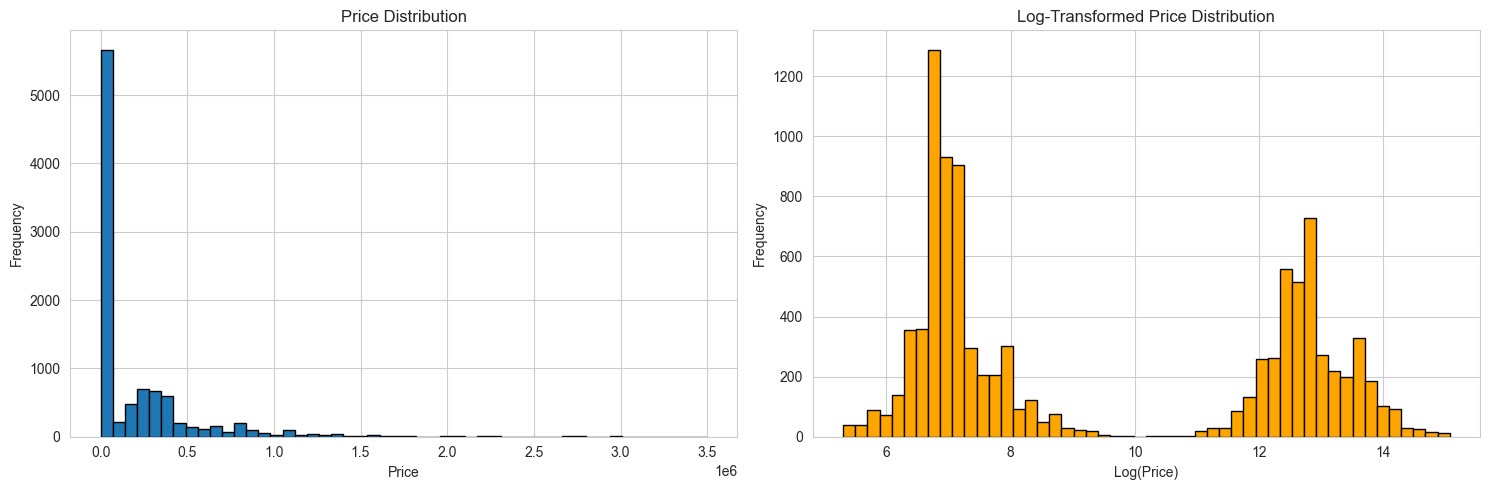

Price Statistics:
Mean: 203393.46
Median: 2500.00
Std: 352273.85
Min: 200.00
Max: 3500000.00


In [7]:
# Distribution of target variable (price)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original price distribution
axes[0].hist(df['price'], bins=50, edgecolor='black')
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Log-transformed price distribution
axes[1].hist(np.log1p(df['price']), bins=50, edgecolor='black', color='orange')
axes[1].set_title('Log-Transformed Price Distribution')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Price Statistics:")
print(f"Mean: {df['price'].mean():.2f}")
print(f"Median: {df['price'].median():.2f}")
print(f"Std: {df['price'].std():.2f}")
print(f"Min: {df['price'].min():.2f}")
print(f"Max: {df['price'].max():.2f}")

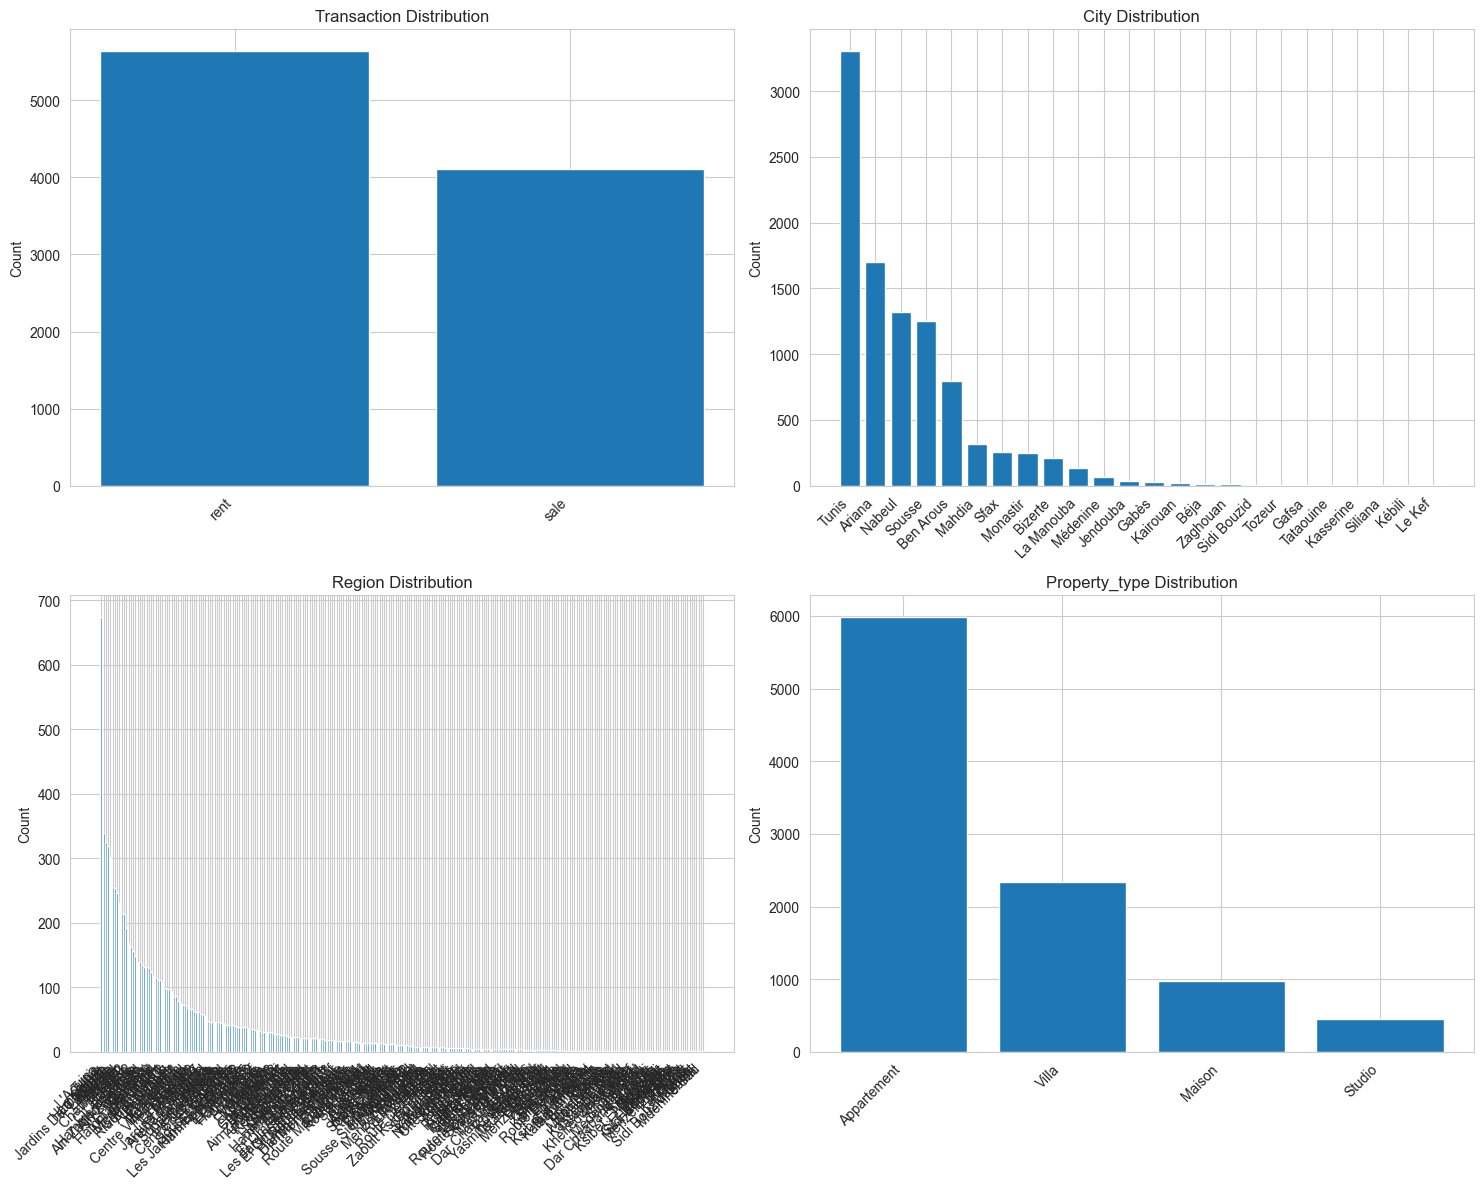

In [8]:
# Categorical features distribution
categorical_features = ['transaction', 'city', 'region', 'property_type']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    value_counts = df[col].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values)
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].set_title(f'{col.capitalize()} Distribution')
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

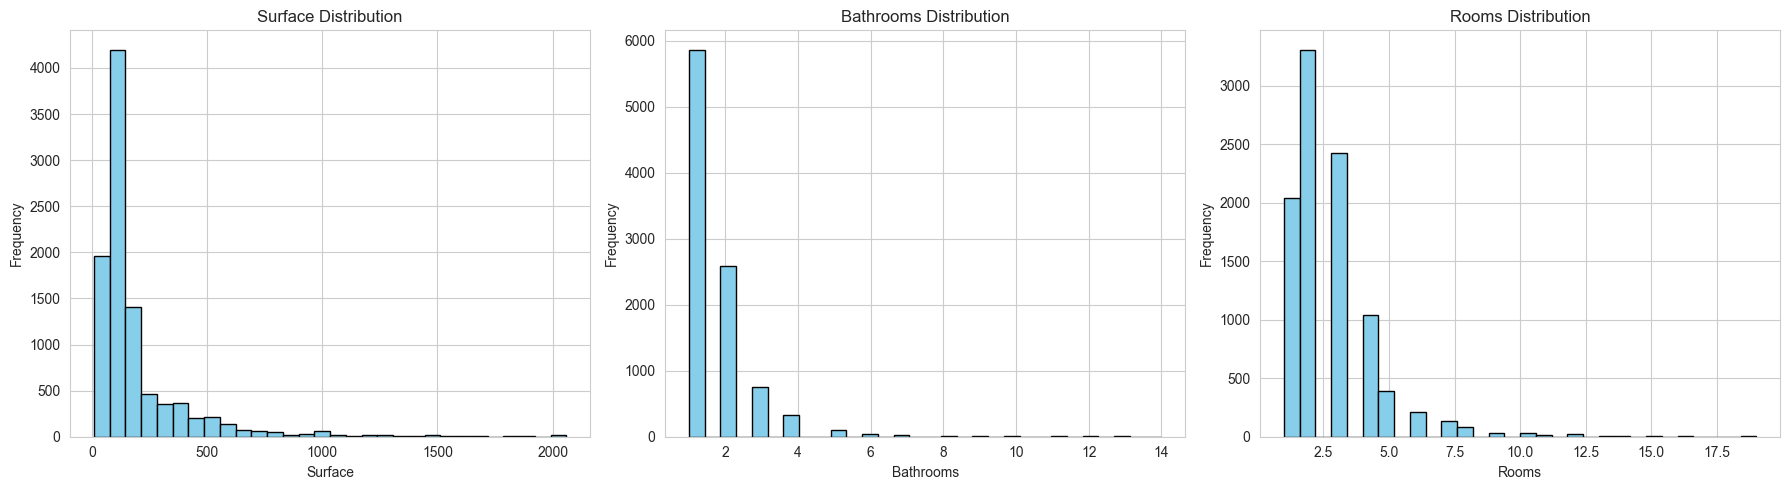

In [9]:
# Numerical features distribution
numerical_features = ['surface', 'bathrooms', 'rooms']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_features):
    axes[idx].hist(df[col], bins=30, edgecolor='black', color='skyblue')
    axes[idx].set_title(f'{col.capitalize()} Distribution')
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

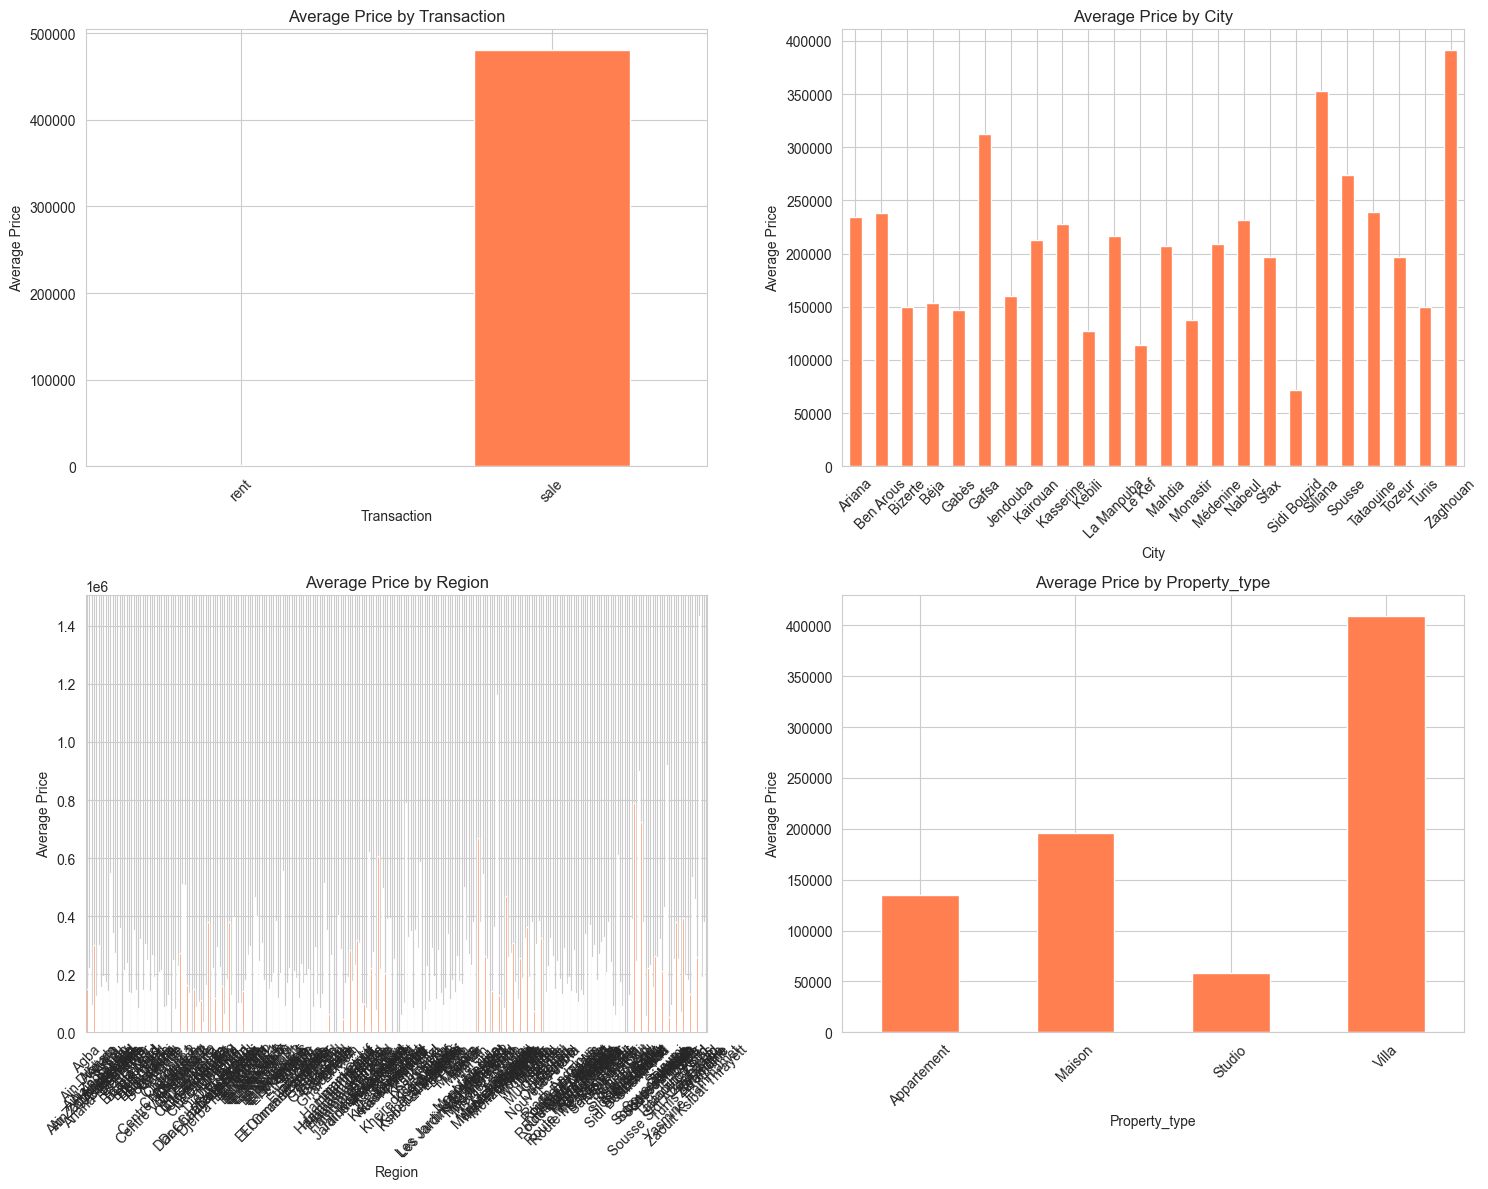

In [10]:
# Price by categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    df.groupby(col)['price'].mean().plot(kind='bar', ax=axes[idx], color='coral')
    axes[idx].set_title(f'Average Price by {col.capitalize()}')
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Average Price')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

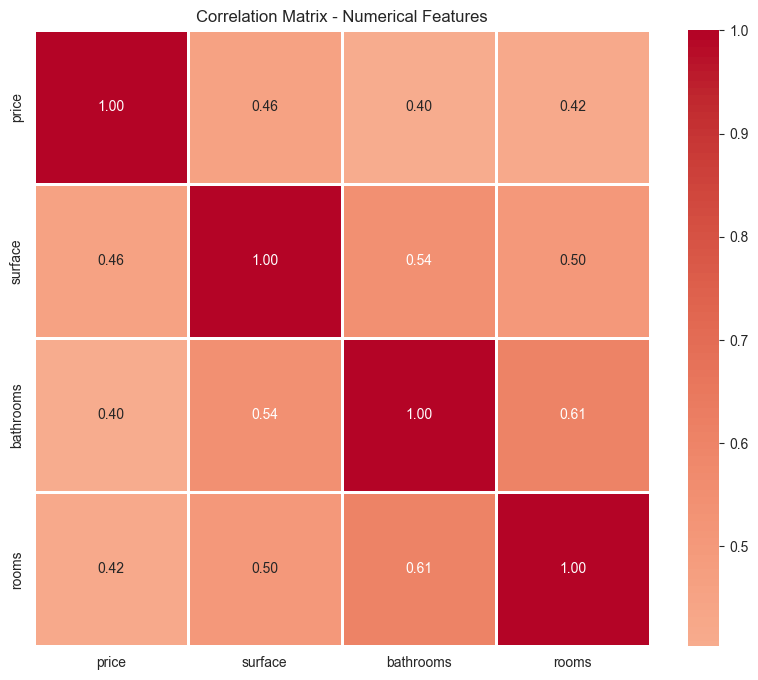

In [11]:
# Correlation matrix for numerical features
numerical_cols = ['price', 'surface', 'bathrooms', 'rooms']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix - Numerical Features')
plt.show()

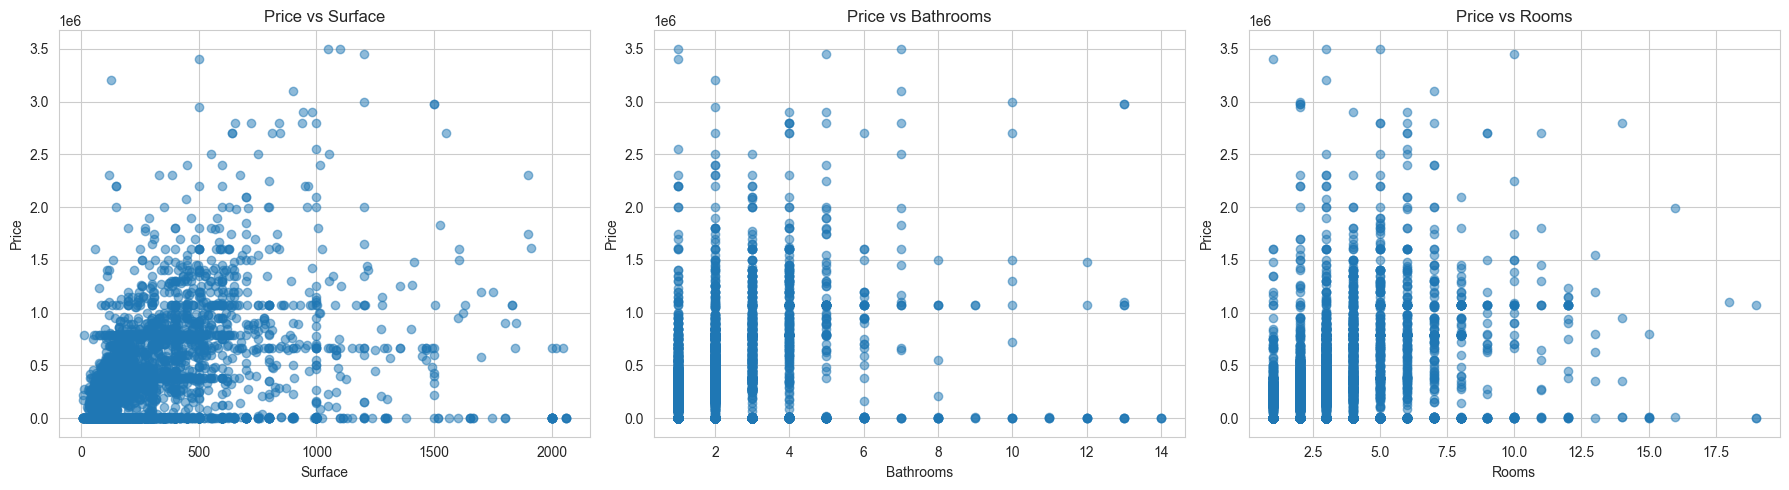

In [12]:
# Scatter plots: numerical features vs price
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_features):
    axes[idx].scatter(df[col], df['price'], alpha=0.5)
    axes[idx].set_xlabel(col.capitalize())
    axes[idx].set_ylabel('Price')
    axes[idx].set_title(f'Price vs {col.capitalize()}')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [13]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values if any
# For numerical features: fill with median
for col in numerical_features:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# For categorical features: fill with mode
for col in categorical_features:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("Missing values after handling:")
print(df_processed.isnull().sum())

Missing values after handling:
price            0
transaction      0
city             0
region           0
surface          0
bathrooms        0
rooms            0
property_type    0
dtype: int64


In [14]:
# Detect and handle outliers (optional - using IQR method)
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Original dataset size: {len(df_processed)}")

# Remove outliers from price (you can adjust or skip this)
df_processed = remove_outliers_iqr(df_processed, 'price', multiplier=3)

print(f"Dataset size after outlier removal: {len(df_processed)}")
print(f"Removed {len(df) - len(df_processed)} outliers")

Original dataset size: 9744
Dataset size after outlier removal: 9502
Removed 242 outliers


In [15]:
# Encode categorical variables
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    
    # Print encoding mapping
    print(f"\n{col} encoding:")
    for idx, label in enumerate(le.classes_):
        print(f"  {label} -> {idx}")


transaction encoding:
  rent -> 0
  sale -> 1

city encoding:
  Ariana -> 0
  Ben Arous -> 1
  Bizerte -> 2
  Béja -> 3
  Gabès -> 4
  Gafsa -> 5
  Jendouba -> 6
  Kairouan -> 7
  Kasserine -> 8
  Kébili -> 9
  La Manouba -> 10
  Le Kef -> 11
  Mahdia -> 12
  Monastir -> 13
  Médenine -> 14
  Nabeul -> 15
  Sfax -> 16
  Sidi Bouzid -> 17
  Siliana -> 18
  Sousse -> 19
  Tataouine -> 20
  Tozeur -> 21
  Tunis -> 22
  Zaghouan -> 23

region encoding:
  Agba -> 0
  Ain Draham -> 1
  Ain Zaghouan Nord -> 2
  Ain Zaghouan Sud -> 3
  Ain Zaghouen -> 4
  Akouda -> 5
  Alain Savary -> 6
  Ariana -> 7
  Ariana Essoughra -> 8
  Ariana Ville -> 9
  Arkou -> 10
  Autres Villes -> 11
  Bab Souika -> 12
  Bekalta -> 13
  Bellevue -> 14
  Bembla -> 15
  Ben Arous -> 16
  Beni Khiar -> 17
  Bizerte -> 18
  Bizerte Nord -> 19
  Bizerte Sud -> 20
  Bja -> 21
  Bja Nord -> 22
  Bni Khalled -> 23
  Bni Khiar -> 24
  Borj Cedria -> 25
  Borj El Amri -> 26
  Borj Louzir -> 27
  Bou Arada -> 28
  Bou Argoub

In [16]:
# Prepare feature matrix and target variable
feature_columns = ['surface', 'bathrooms', 'rooms', 
                   'transaction_encoded', 'city_encoded', 
                   'region_encoded', 'property_type_encoded']

X = df_processed[feature_columns]
y = df_processed['price']

print("Feature matrix shape:", X.shape)
print("Target variable shape:", y.shape)
print("\nFeatures used:")
print(feature_columns)

Feature matrix shape: (9502, 7)
Target variable shape: (9502,)

Features used:
['surface', 'bathrooms', 'rooms', 'transaction_encoded', 'city_encoded', 'region_encoded', 'property_type_encoded']


In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7601
Test set size: 1901


In [18]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("Data scaling completed!")

Data scaling completed!


In [21]:
# Save preprocessed data for modeling
import pickle
from pathlib import Path

base_dir = Path("C:/Users/Mediatek/Desktop/ML-project/ML")
if not base_dir.exists():
    base_dir = Path.cwd()

output_path = base_dir / "data" / "preprocessed_data.pkl"
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save the preprocessed data
with open(output_path, 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_columns': feature_columns
    }, f)

print(f"Preprocessed data saved to: {output_path}")

Preprocessed data saved to: C:\Users\Mediatek\Desktop\ML-project\ML\data\preprocessed_data.pkl


In [23]:
# Save combined dataset for MLflow (rent + sale together)
import os
from pathlib import Path
import joblib

# Direct path to ML directory
ML_DIR = Path("C:/Users/Mediatek/Desktop/ML-project/ML")

if not ML_DIR.exists():
    # Fallback: try to locate ML directory
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parents[1] if len(Path.cwd().parents) > 1 else Path.cwd(),
    ]
    for p in candidates:
        if (p / "data").exists() and "ML" in str(p):
            ML_DIR = p
            break

prepared_dir = ML_DIR / "data" / "combined"
preprocessing_dir = ML_DIR / "data"
os.makedirs(prepared_dir, exist_ok=True)
os.makedirs(preprocessing_dir, exist_ok=True)

np.save(prepared_dir / "X_train.npy", X_train_scaled)
np.save(prepared_dir / "X_test.npy", X_test_scaled)
np.save(prepared_dir / "y_train.npy", y_train.to_numpy())
np.save(prepared_dir / "y_test.npy", y_test.to_numpy())

joblib.dump(
    {
        "scaler": scaler,
        "label_encoders": label_encoders,
        "feature_columns": feature_columns
    },
    preprocessing_dir / "preprocessor_combined.joblib"
 )

print("✅ Combined dataset saved for MLflow")
print(f"   Prepared: {prepared_dir}")
print(f"   Preprocessor: {preprocessing_dir / 'preprocessor_combined.joblib'}")

✅ Combined dataset saved for MLflow
   Prepared: C:\Users\Mediatek\Desktop\ML-project\ML\data\combined
   Preprocessor: C:\Users\Mediatek\Desktop\ML-project\ML\data\preprocessor_combined.joblib


## Summary

In this notebook, we:
1. Loaded and explored the real estate dataset
2. Visualized distributions and relationships
3. Handled missing values and outliers
4. Encoded categorical variables
5. Split data into train/test sets
6. Scaled numerical features
7. Saved preprocessed data for modeling

Next steps: Use the preprocessed data in modeling notebooks to test different algorithms!